## XGBoost Solar Generation Model — 2023 - 2025

This notebook builds an XGBoost regression model to predict daily solar generation using historical weather and calendar features. The goal is to evaluate whether incorporating data from April 2023 to June 2025 improves on the 2024 only XGBoost model.

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

### Load and View Data

In [9]:
# Load Cleaned Data and view head
df = pd.read_csv("../../Cleaned Data/Cleaned_National_Irish_Weather_Solar_2023-2025.csv", parse_dates=['date'])

df.head()

,date,rain,maxtp,mintp,glorad,solargen
0,2023-04-01,2.99,11.81,5.82,1088.88,2127.56
1,2023-04-02,0.00,12.19,3.68,1329.00,2666.57
2,2023-04-03,0.54,11.25,5.64,731.12,2370.33
3,2023-04-04,4.15,12.04,7.10,835.75,3397.26
4,2023-04-05,2.44,13.50,7.40,820.00,2005.28


### Parse Dates and Add Seasonal Features

In [593]:
# Convert to datetime and extract useful calendar features
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['month'] = df['date'].dt.month
df['dayofyear'] = df['date'].dt.dayofyear
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

### Scale Solar Generation Data to Adjust for Yearly Capacity Increases 2023-2025

In [ ]:
df['year'] = df['date'].dt.year

# Calculate the 95th percentile daily solar generation per year
percentiles_95 = df.groupby('year')['solargen'].quantile(0.95)
print("Original 95th Percentiles:")
print(percentiles_95)

# Use 2024 as the reference capacity level
ref_year = 2024
ref_value = percentiles_95.loc[ref_year]

# Compute scaling factors for each year
scaling_factors = percentiles_95.apply(lambda x: ref_value / x)
print("\nScaling Factors (relative to 2024):")
print(scaling_factors)

# Apply scaling factors to solar generation
df['solargen_scaled'] = df.apply(
    lambda row: row['solargen'] * scaling_factors.loc[row['year']],
    axis=1
)

# Check new percentiles after scaling
new_percentiles_95 = df.groupby('year')['solargen_scaled'].quantile(0.95)
print("\nNew 95th Percentiles After Scaling:")
print(new_percentiles_95)


### Select Features and Target

In [525]:
# Feature selection
features = ['glorad', 'rain', 'maxtp', 'mintp', 'month', 'dayofyear', 'sin_doy', 'cos_doy']
X = df[features]
y = df['solargen_scaled']

### Train/Test Split

In [526]:
# Random 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Fit XGBoost Model

In [588]:
# Updated paramters after grid search
model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=400,
    reg_alpha=0.5,
    reg_lambda=1,
    min_child_weight=11,
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Evaluate Model Performance

In [589]:
# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train: R²: {r2_train:.3f} | RMSE: {rmse_train:.2f} | MAE: {mae_train:.2f}")

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Test : R²: {r2_test:.3f} | RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f}")

Train: R²: 0.988 | RMSE: 591.35 | MAE: 434.98
Test : R²: 0.833 | RMSE: 2074.54 | MAE: 1478.73


### GridSearch for XGBoost Tuning

In [171]:
from sklearn.model_selection import GridSearchCV

# Define basic parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [80, 90, 100, 120],
    'reg_lambda': [0.5, 1, 2],
    'reg_alpha': [0, 0.5, 1]
}

# Set up the regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run Grid Search
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 80, 'reg_alpha': 0.5, 'reg_lambda': 2}


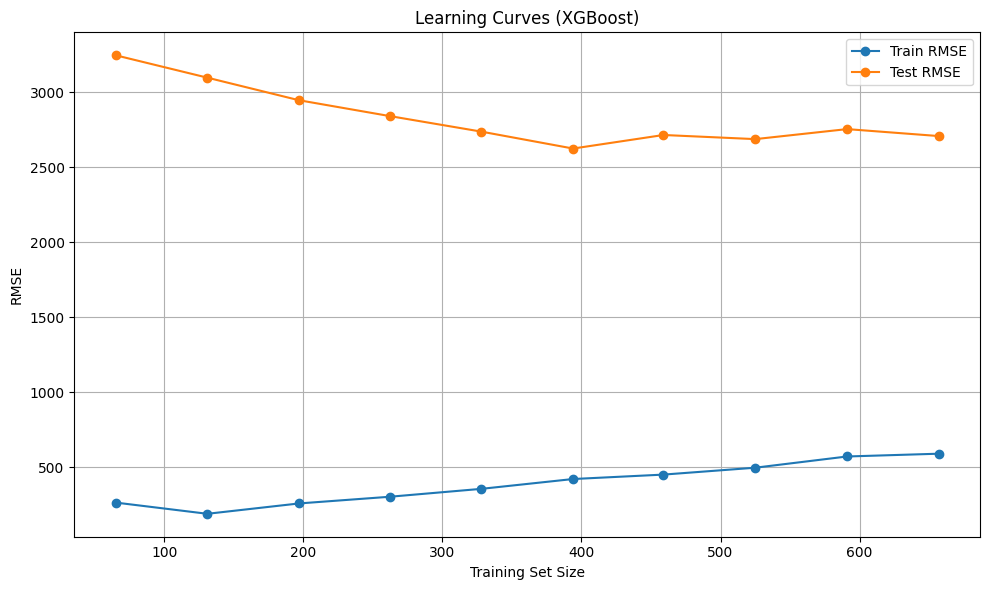

In [590]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


# Use RMSE scorer
def rmse_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

# Set up learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,              
    X, y,                
    cv=5,                
    scoring=rmse_score,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Compute mean RMSE
train_rmse = -np.mean(train_scores, axis=1)
test_rmse = -np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Train RMSE', marker='o')
plt.plot(train_sizes, test_rmse, label='Test RMSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curves (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Plot Feature Importance

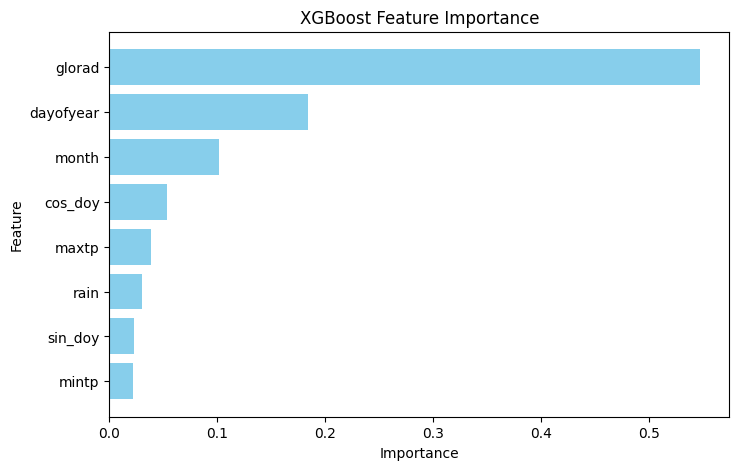

In [ ]:
# Get feature importances from trained model
importance = model.feature_importances_
feature_names = X.columns

# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis() 


### Save Current Model

In [591]:
import joblib
joblib.dump(model, '../../models/XGBoost_2023-2025_Model.pkl')


['../../models/XGBoost_2023-2025_Model.pkl']